## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import get_toy_data_indep, id, expy2

from src.attacks.point_attacks import attack, attack_fgsm, true_gradient_mean, reparametrization_trick, det_attack

import numpy as np
import torch
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Toy data
X, y = get_toy_data_indep()

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
# Fit the model
model = NormalKnownVariancePriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'sigma2': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

In [7]:
model.sample_predictive_distribution(torch.tensor(X_test[17,:], dtype=torch.float32).unsqueeze(1), 1000).mean()

tensor(-0.5315)

## Check gradients

Text(0, 0.5, 'Counts')

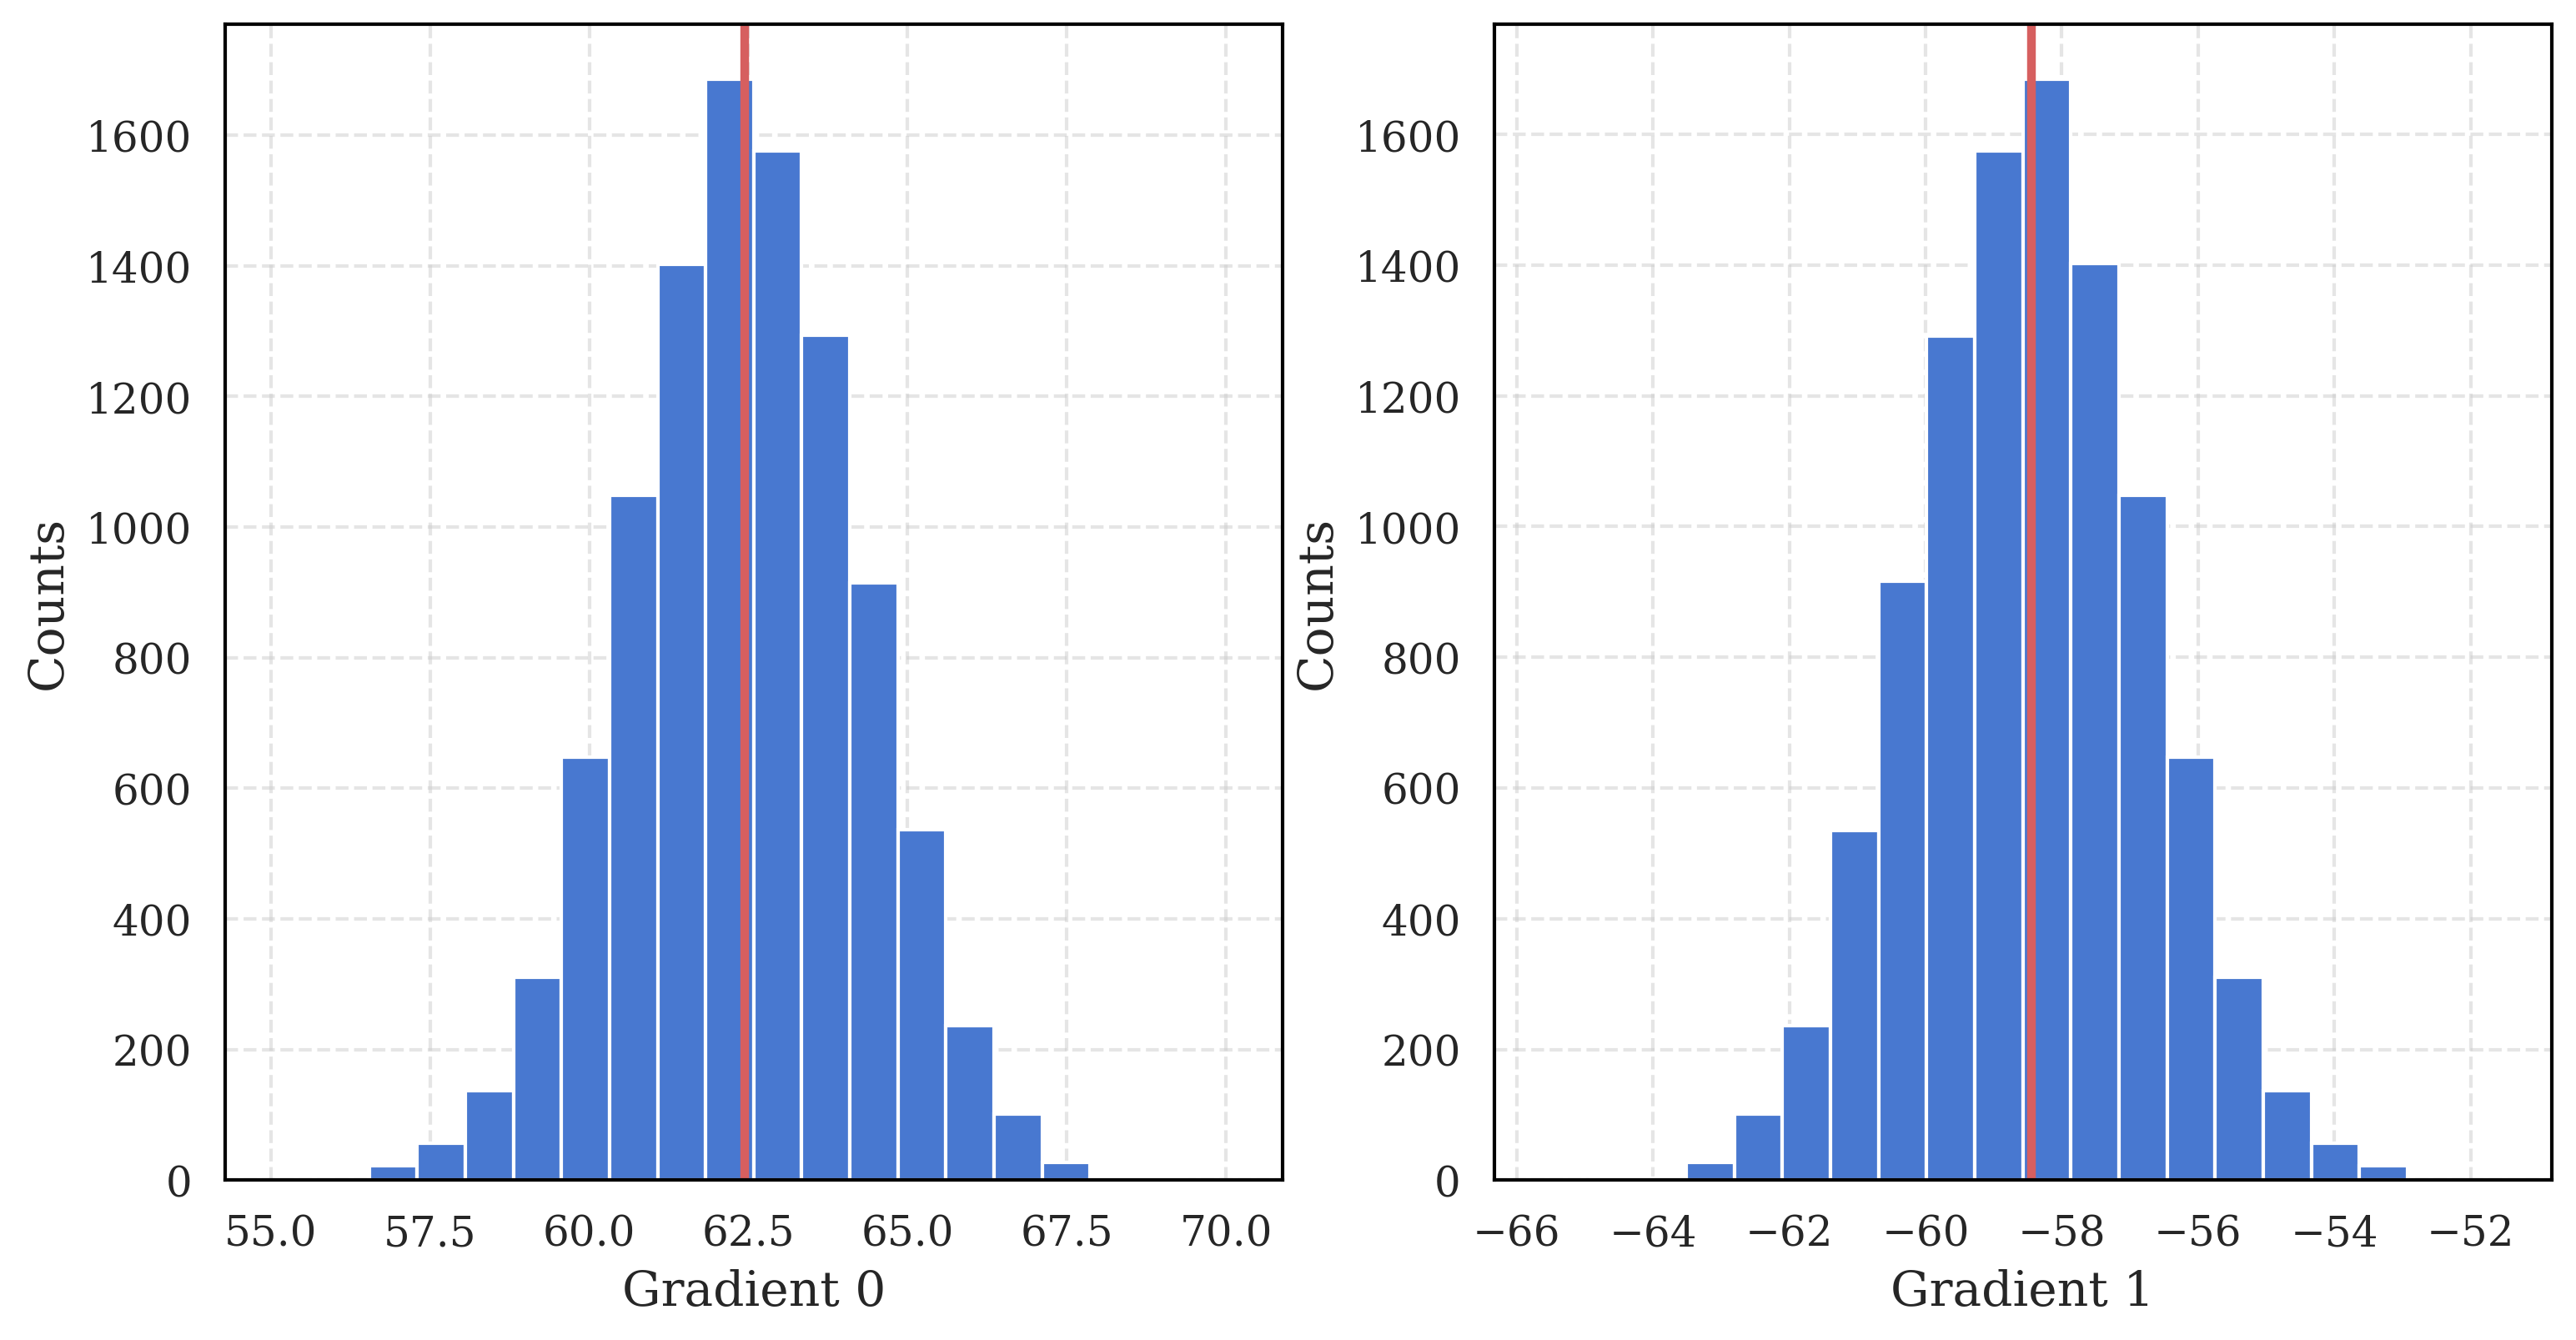

In [8]:
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
y_star = 3.0
grads = []
exact_gradient = true_gradient_mean(x_adv, model, y_star)

for _ in range(10000):
    rep_gradients, _, _ = reparametrization_trick(x_adv, model, y_star, 100, id)
    grads.append(rep_gradients.clone().numpy())
    x_adv.grad.zero_()
    

# plot histogram of gradients
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(np.array(grads)[:, 0], bins=20)
# plot line at exact_gradient[0]
axs[0].axvline(exact_gradient[0].item(), color='r')

axs[1].hist(np.array(grads)[:, 1], bins=20)
# plot line at exact_gradient[1]
axs[1].axvline(exact_gradient[1].item(), color='r')

# label the axes
axs[0].set_xlabel('Gradient 0')
axs[0].set_ylabel('Counts')
axs[1].set_xlabel('Gradient 1')
axs[1].set_ylabel('Counts')

## Vector field of perturbations for toy dataset

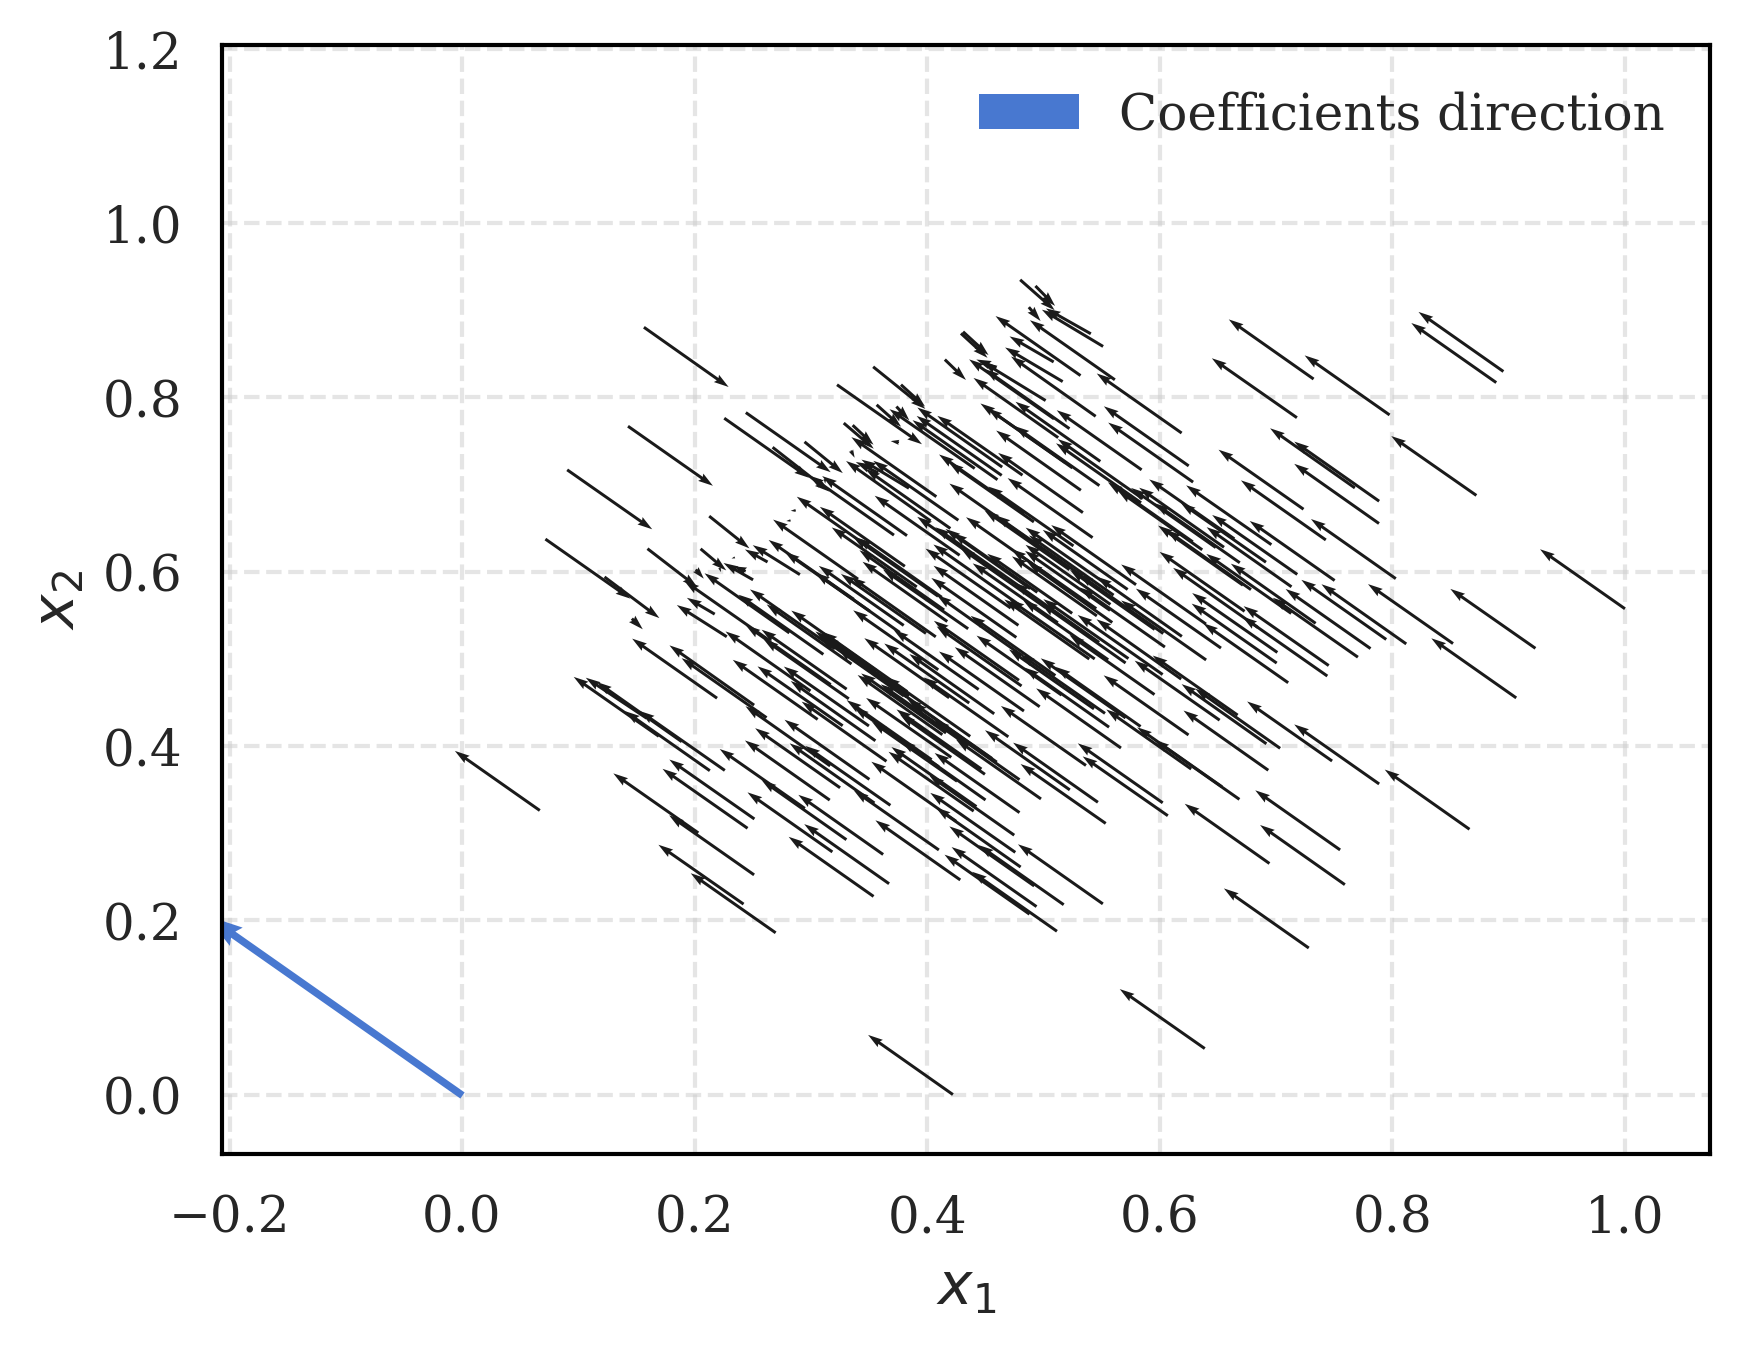

In [9]:
# Vector field of perturbations
y_star = 3.0
epsilon = 0.1

perturbations = []

for i in range(X_test.shape[0]):
    x_adv = torch.tensor(X_test[i,:].copy(), dtype=torch.float32, requires_grad=True)
    x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, samples_per_iteration=100, learning_rate=1e-4, num_iterations=1000, func=id)
    perturbations.append(x_adv_values[-1] - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.2,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

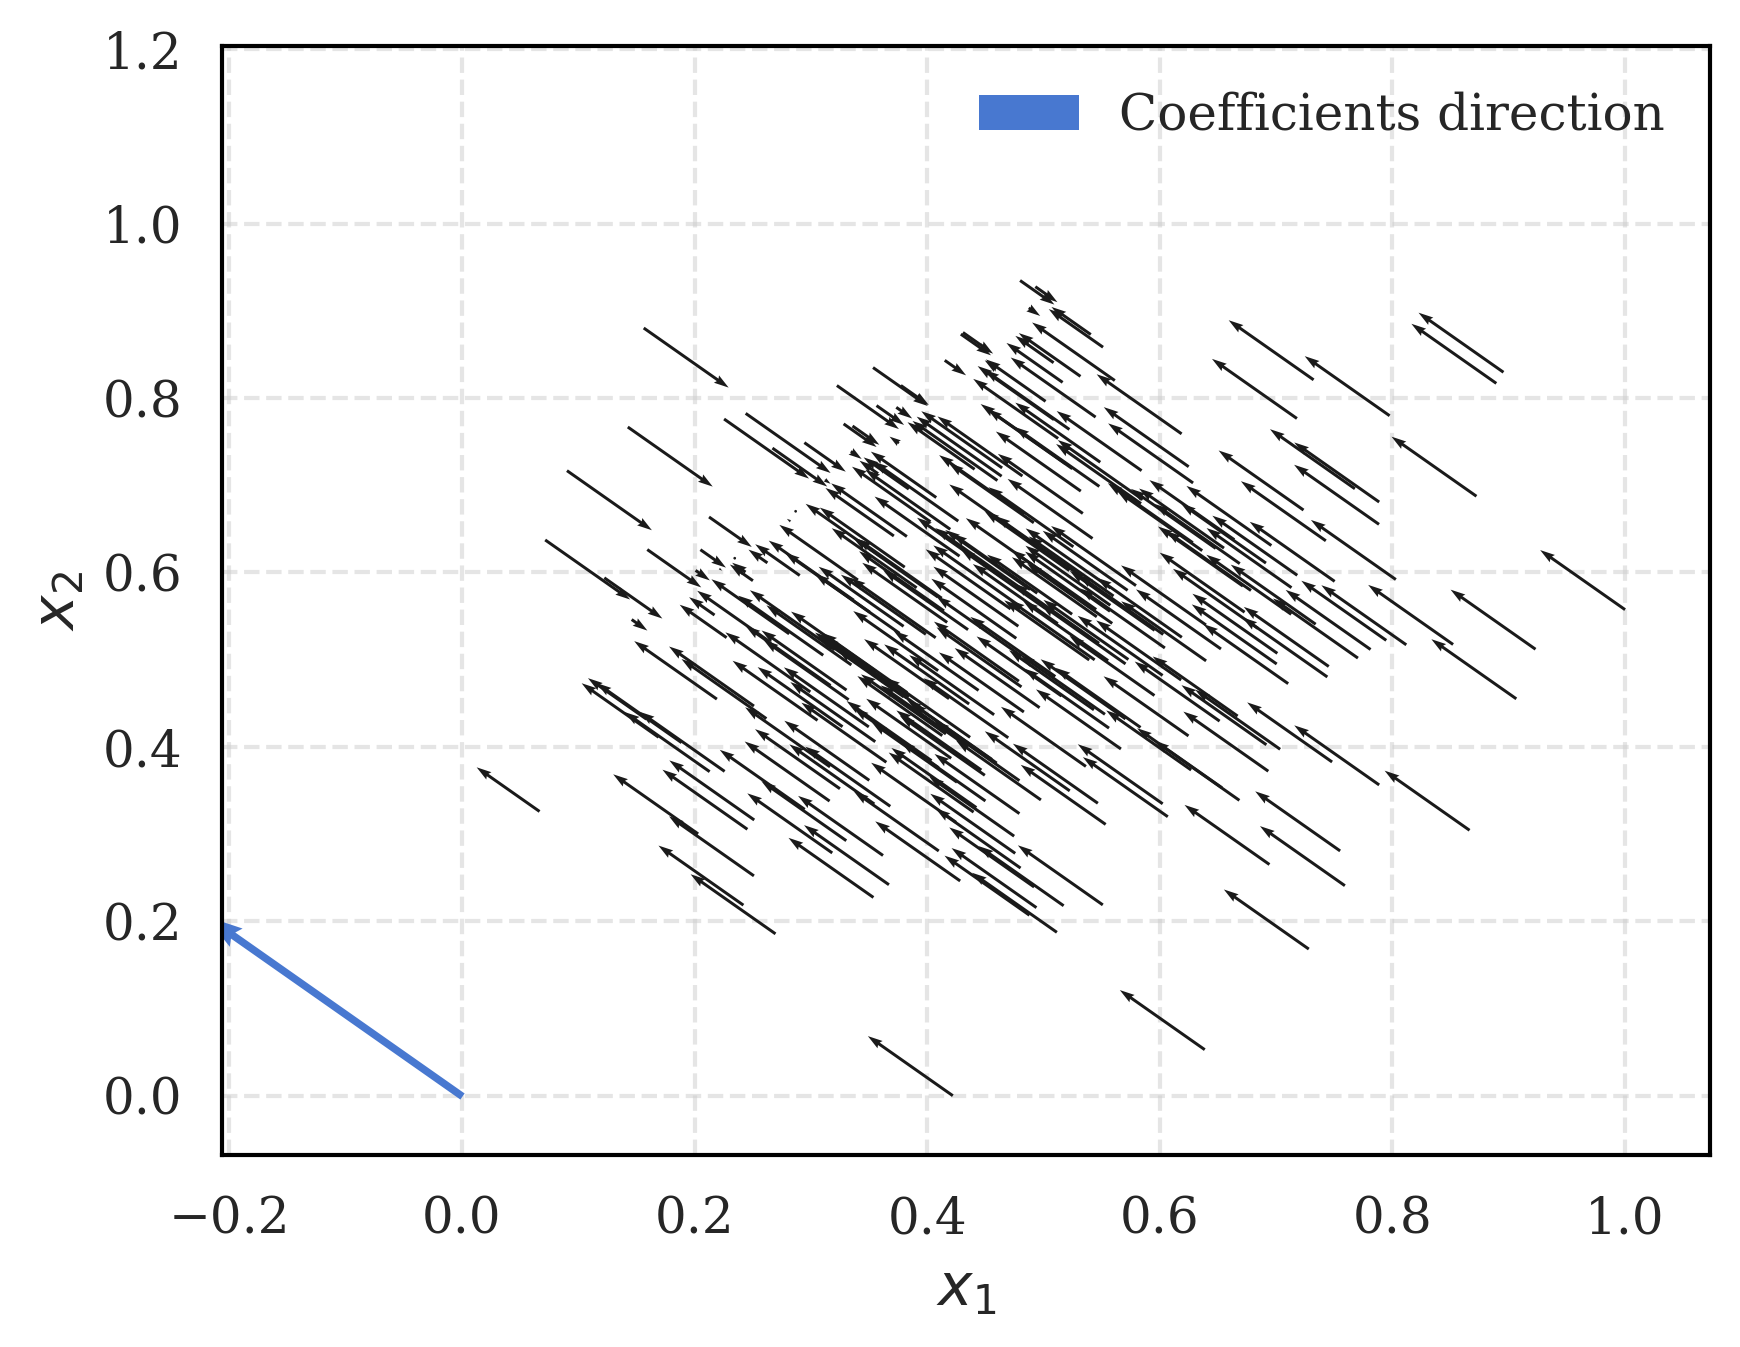

In [10]:
# Vector field of perturbations
y_star = 3.0
epsilon = 0.1

perturbations = []

for i in range(X_test.shape[0]):
    x_adv = torch.tensor(X_test[i,:].copy(), dtype=torch.float32)
    x_adv_det, _ = det_attack(x_adv, model, y_star, epsilon=epsilon)
    perturbations.append(x_adv_det.numpy() - x_adv.clone().detach().numpy())

plt.quiver(X_test[:,0], X_test[:,1], np.array(perturbations)[:,0], np.array(perturbations)[:,1], 
           width=0.002, angles='xy', scale_units='xy', scale=1)

# add beta direction
mu = model.mu.numpy()
plt.quiver(0, 0, mu[0], mu[1], color='b',
           width=0.005, angles='xy', scale_units='xy', scale=40, label='Coefficients direction')
plt.xlim(min(X_test[:,0]) + min(np.array(perturbations)[:,0])-.2,max(X_test[:,0]) + max(np.array(perturbations)[:,0]))
plt.ylim(min(X_test[:,1]) + min(np.array(perturbations)[:,1]),max(X_test[:,1]) + max(np.array(perturbations)[:,1]) + 0.2)  # room for legend
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

## Security evaluation plot

<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2927193/2066330836.py:38: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


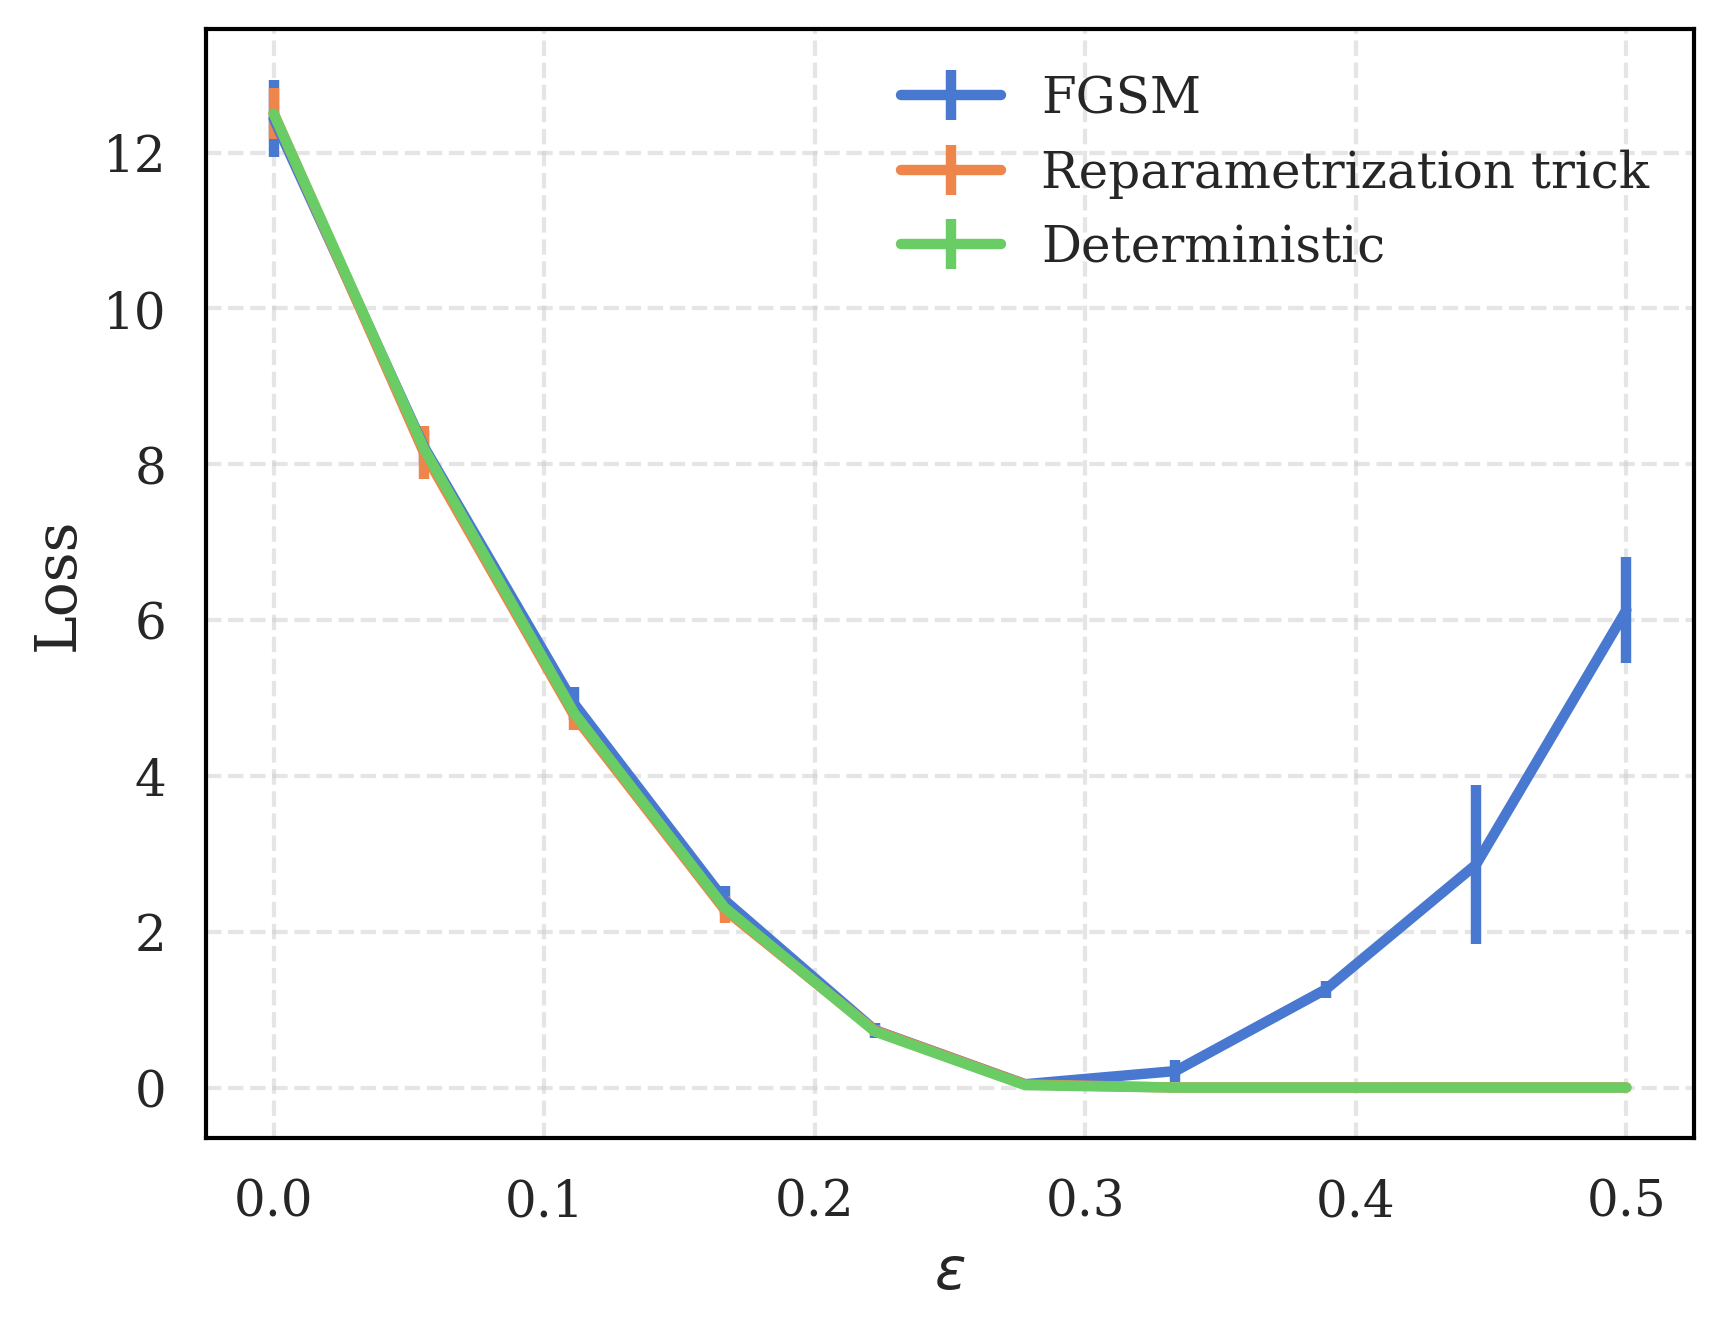

In [23]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
y_star = 3

losses_det_all = []
losses_rep_all = []
losses_fgsm_all = []
epsilons = np.linspace(0, .5, 10)

for _ in range(10):
    losses_det = []
    losses_rep = []
    losses_fgsm = []

    for epsilon in epsilons:
        x_adv_det, y_adv_det = det_attack(X_test[17,:].copy(), model, y_star, epsilon, verbose=False)
        losses_det.append((y_adv_det - y_star) ** 2)
        if epsilon > .3:
            lr = 1e-5
        else: 
            lr = 1e-4
        x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=lr, func=id, samples_per_iteration=1000, num_iterations=2000)   
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000).mean().item() 
        losses_rep.append((y_adv - y_star) ** 2)

        x_adv_fgsm = attack_fgsm(torch.tensor(X_test[17,:].copy(), dtype=torch.float32), model, y_star, epsilon=epsilon)
        y_adv_fgsm = model.sample_predictive_distribution(x_adv_fgsm.unsqueeze(1), 1000).mean().item()
        losses_fgsm.append((y_adv_fgsm - y_star) ** 2)

    losses_det_all.append(losses_det)
    losses_rep_all.append(losses_rep)
    losses_fgsm_all.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_fgsm_all, axis=0), yerr=2*np.std(losses_fgsm_all, axis=0), label='FGSM')
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_det_all, axis=0), yerr=2*np.std(losses_det_all, axis=0), label='Deterministic')
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.legend()

In [34]:
x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=.2, learning_rate=1e-4, func=id, samples_per_iteration=1000, num_iterations=2000)   
y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000).mean().item() 
print(y_adv)

x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=.3, learning_rate=1e-4, func=id, samples_per_iteration=1000, num_iterations=2000)   
y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000).mean().item() 
print(y_adv)

1.9346742630004883
3.0516796112060547
